### Improvements 
## IMP: Fitrar por la surface--remove events that move out of the surface on the first 3 secons
1) Remove blinks and interpolate values using cubic splines
2) Blank filtering of data---Done-- maibe explore other filter
3) Frequency analysis of the signal??
4) Remove trials with z scores over [2,-2]
5) Convert time to seconds
6) Open PLA file
7) Statistics of signal ¿How to compare surprise signals?
8) Amplitud, velocidad de cambio
9) Cut the whole signal of interest from the beggining
10) Fitrar por la surface


### Simple pupillometry code to merge different experiments


In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import sys
sys.path.append('../')
import commons as cm
from data_curation import Normalization
from pandasql import sqldf

nm=Normalization()

session_location = Path(r"P:\Proyectos\2020\PY200016 - XSCAPE\Trabajo\00 XPERIMENTS\01 EXPERIMENTS_Santiago\01 ONGOING\Exp_Stgo_0001\SESSIONS")
sessions=[]

with open('session.txt','r') as f:
    for session in f:
            sessions.append(session.replace('\n',''))
f.close()

session_loc_list=[session_location.joinpath(session,'01 Processing_data','pupil_labs') for session in sessions ]
session_raw_list=[session_location.joinpath(session, '00 Raw_data','pupil_labs') for session in sessions ]

image_loc_list=[session_location.joinpath(session,'images_order') for session in sessions ]

In [2]:
recording_location=session_loc_list[0]
recording_folder=[record for record in os.listdir(recording_location)  if '00' in record]


if len(recording_folder)>1:
    ValueError('Ambiguty in folder of experiment')


recording_location=recording_location.joinpath(recording_folder[0],'exports')
recording_location_raw=recording_location.joinpath(recording_folder[0],'exports')

export_folder=[record for record in os.listdir(recording_location)  if '00' in record]
if len(export_folder)>1:
    ValueError('Ambiguty in folder of exports')
recording_location=recording_location.joinpath(export_folder[0])


gaze_surf_csv=[record for record in os.listdir(recording_location.joinpath('surfaces'))  if 'gaze_positions' in record][0]


In [3]:
exported_pupil_csv = recording_location.joinpath('pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)
exported_gaze_csv = os.path.join(recording_location,'gaze_positions.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location,'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)
surface_gaze_csv = os.path.join(recording_location, 'surfaces',gaze_surf_csv)
surfaces_pd_frame = pd.read_csv(surface_gaze_csv)



### Filter data that is inside the surface
#### Due to the fact that te gaze timesatmp of the surface is obtained by combining data from both pupils we cant just merge by the timestamp. We have to read and duplicate values

In [4]:
pupil_pd_frame['join_index']=np.nan
surfaces_pd_frame['join_index']=np.nan


In [5]:
# pupil_list=[]
# surface_list=[]
# ref_col_gaze=surfaces_pd_frame.columns.get_indexer(['gaze_timestamp'])[0]
# ref_col_index=surfaces_pd_frame.columns.get_indexer(['join_index'])[0]

# timestamps=pupil_pd_frame['pupil_timestamp'].values

# for row in range(surfaces_pd_frame.shape[0]-1):
#         ini_value=surfaces_pd_frame.iloc[row,ref_col_gaze]
#         end_value=surfaces_pd_frame.iloc[row+1,ref_col_gaze]
#         # print(ini_value,end_value)
#         index_1=(timestamps>=ini_value)&(timestamps< end_value)
          
#         pupil_pd_frame.loc[index_1,['join_index']]=row
#         surfaces_pd_frame.iloc[row,ref_col_index]=row
# final_df=pd.merge(pupil_pd_frame, surfaces_pd_frame, on="join_index", how="left",suffixes=['','_sur'])
# final_df.head()


In [6]:
# surfaces_pd_frame['start']=surfaces_pd_frame['gaze_timestamp']
# surfaces_pd_frame['end']=np.append(surfaces_pd_frame['gaze_timestamp'].values[1:],0)
# surfaces_pd_frame.drop(surfaces_pd_frame.tail(1).index,inplace=True)
# surfaces_pd_frame
# df= pd.merge_asof(pupil_pd_frame, surfaces_pd_frame, left_on='pupil_timestamp', right_on='start', direction='forward',suffixes=['','_sur'])
# df = df[df['pupil_timestamp'] <= df['end']]
# pupil_pd_frame=df

### Cut all data by annotations of interest

In [7]:
# pupil_pd_frame=final_df

from IPython.display import display

event_initial=annotations_pd['label'].values[0]
event_final=annotations_pd['label'].values[-1]

initial_anotation,_,_=cm.extract_annotations_timestamps(event_initial,'label',annotations_pd)
end_anotation=annotations_pd.iloc[-1]
display(initial_anotation)
display(end_anotation)

pupil_pd_frame=cm.filter_rows_by_temporal_values(
         dataframe=pupil_pd_frame,
         time_column='pupil_timestamp',
         ini_value=initial_anotation['timestamp'].values[0],
         end_value=end_anotation['timestamp']
         )

,index,timestamp,label,duration
0,7625,9572.150979,blank_0,NaN


index                  39854
timestamp       10112.144156
label        EndOfExperiment
duration                 NaN
Name: 162, dtype: object

## Extract the data
Extracting pupil 3d data for analysis

In [8]:
from IPython.display import display
pupil_pd_frame['on_surf']=True
confidence_thr=1
 
# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

pupil_left_eye_interpolated=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1)& (pupil_pd_frame['on_surf']==True)]
pupil_right_eye_interpolated=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0)& (pupil_pd_frame['on_surf']==True)]

left_conf_index=(pupil_left_eye_interpolated['confidence']>=confidence_thr).values
right_conf_index=(pupil_right_eye_interpolated['confidence']>=confidence_thr).values

pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)]
pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)]

blinks_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']< confidence_thr)]
blinks_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']< confidence_thr)]

pupil_left_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]
pupil_right_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]

pupil_left_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]
pupil_right_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]

blinks_left_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']< confidence_thr)& (pupil_pd_frame['on_surf']==True)]
blinks_right_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']< confidence_thr)& (pupil_pd_frame['on_surf']==True)]

out_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]

In [9]:
pupil_left_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(
                                                x=pupil_left_eye_interpolated.loc[left_conf_index,['pupil_timestamp']].values.flatten(),
                                                y= pupil_left_eye_interpolated.loc[left_conf_index,['diameter_3d']].values.flatten(),
                                                x_interpolate=pupil_left_eye_interpolated['pupil_timestamp'].values.flatten()
                                                )

pupil_right_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(
                                                x=pupil_right_eye_interpolated.loc[right_conf_index,['pupil_timestamp']].values.flatten(),
                                                y= pupil_right_eye_interpolated.loc[right_conf_index,['diameter_3d']].values.flatten(),
                                                x_interpolate=pupil_right_eye_interpolated['pupil_timestamp'].values.flatten()
                                                )


filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 
filter_events_all=~annotations_pd['label'].str.contains('EndOfExperiment') 


filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')

print("eye0 (right eye) data:")
display(pupil_right_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(pupil_left_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))


eye0 (right eye) data:


C:\Users\arturoV\AppData\Local\Temp\ipykernel_13156\1084852889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(
C:\Users\arturoV\AppData\Local\Temp\ipykernel_13156\1084852889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
29719,9572.169202,0,1.0,0.324405,0.534213,6.253656
29731,9572.193114,0,1.0,0.324547,0.533762,6.242186
29758,9572.249205,0,1.0,0.324346,0.534391,6.250127
29762,9572.257196,0,1.0,0.324348,0.534489,6.251022
29771,9572.273236,0,1.0,0.324532,0.534570,6.253679
29779,9572.289197,0,1.0,0.324260,0.534487,6.252661
29786,9572.305190,0,1.0,0.324429,0.534535,6.251123
29790,9572.317067,0,1.0,0.324724,0.534523,6.260817
29811,9572.357182,0,1.0,0.324531,0.534123,6.255196
29818,9572.373185,0,1.0,0.324623,0.534170,6.246114


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
29753,9572.237214,1,1.0,0.410697,0.409990,4.678681
29764,9572.261283,1,1.0,0.411005,0.409822,4.671783
29798,9572.333201,1,1.0,0.410769,0.409980,4.680658
29832,9572.397243,1,1.0,0.411086,0.410369,4.662371
29856,9572.445203,1,1.0,0.414414,0.401879,4.656652
29872,9572.477340,1,1.0,0.415122,0.399138,4.649022
30119,9572.977231,1,1.0,0.414299,0.399188,4.630336
30173,9573.085216,1,1.0,0.414492,0.399084,4.626332
30225,9573.189192,1,1.0,0.414579,0.399286,4.631597
30269,9573.277209,1,1.0,0.415150,0.399138,4.638862


df to analyse


In [10]:
pupil_left_eye=pupil_left_eye
pupil_right_eye=pupil_right_eye

blinks_left_eye=blinks_left_eye
blinks_right_eye=blinks_right_eye

In [11]:
recording_location
parts = list(recording_location.parts)
parts=parts[0:-2]
parts=Path(*parts)
parts

WindowsPath('P:/Proyectos/2020/PY200016 - XSCAPE/Trabajo/00 XPERIMENTS/01 EXPERIMENTS_Santiago/01 ONGOING/Exp_Stgo_0001/SESSIONS/ES0001_S020_PC_EM/01 Processing_data/pupil_labs/001')

In [12]:
import json
f = open(parts.joinpath('info.player.json'))
data = json.load(f)
time_whole_recording=data['duration_s']
time_roi_left=abs(pupil_left_eye['pupil_timestamp'].values[-1]-pupil_left_eye['pupil_timestamp'].values[0])
time_roi_right=abs(pupil_right_eye['pupil_timestamp'].values[-1]-pupil_right_eye['pupil_timestamp'].values[0])

pupil_sampling_freq_left=(pupil_left_eye.shape[0]+blinks_left_eye.shape[0])/time_roi_left
pupil_sampling_freq_right=(pupil_right_eye.shape[0]+blinks_right_eye.shape[0])/time_roi_right 
print('sampling frequency for right eye is {}'.format(pupil_sampling_freq_right)) 
print('sampling frequency for left eye is {}'.format(pupil_sampling_freq_left)) 

# Closing file
f.close()


sampling frequency for right eye is 123.97295546251496
sampling frequency for left eye is 123.95094581632272


##  Explore blinks and Asses data quality, are there many regions with data gaps? 


### Asses data quality

In [13]:
total_blinks_left=blinks_left_eye.shape[0]/pupil_sampling_freq_left
total_blinks_right=blinks_right_eye.shape[0]/pupil_sampling_freq_right
print(f'Total blinks time left {total_blinks_left:.2f}s and right {total_blinks_right:.2f}s of a total of {time_roi_left:.2f}s left and {time_roi_right:.2f}s right')
print(f'Total blinks time left {total_blinks_left/time_roi_left:.2%} ')
print(f'Total blinks time right {total_blinks_right/time_roi_right:.2%} ')


Total blinks time left 49.63s and right 161.87s of a total of 539.90s left and 539.79s right
Total blinks time left 9.19% 
Total blinks time right 29.99% 


## Put timestamp data in seconds


In [14]:
pupil_left_eye['timestamp_s']=pupil_left_eye['pupil_timestamp']-pupil_left_eye['pupil_timestamp'].values[0]
pupil_left_eye['timestamp_s']

pupil_right_eye['timestamp_s']=pupil_right_eye['pupil_timestamp']-pupil_right_eye['pupil_timestamp'].values[0]
pupil_right_eye['timestamp_s']

annotations_pd['timestamp_s']=annotations_pd['timestamp']-annotations_pd['timestamp'].values[0]


C:\Users\arturoV\AppData\Local\Temp\ipykernel_13156\2321012662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye['timestamp_s']=pupil_left_eye['pupil_timestamp']-pupil_left_eye['pupil_timestamp'].values[0]
C:\Users\arturoV\AppData\Local\Temp\ipykernel_13156\2321012662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye['timestamp_s']=pupil_right_eye['pupil_timestamp']-pupil_right_eye['pupil_timestamp'].values[0]


### View Raw data

Text(0.5, 1.0, 'Both eyes')

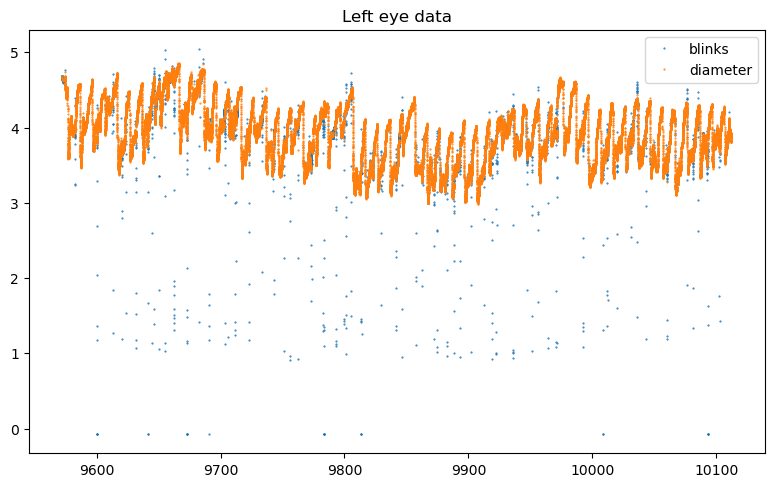

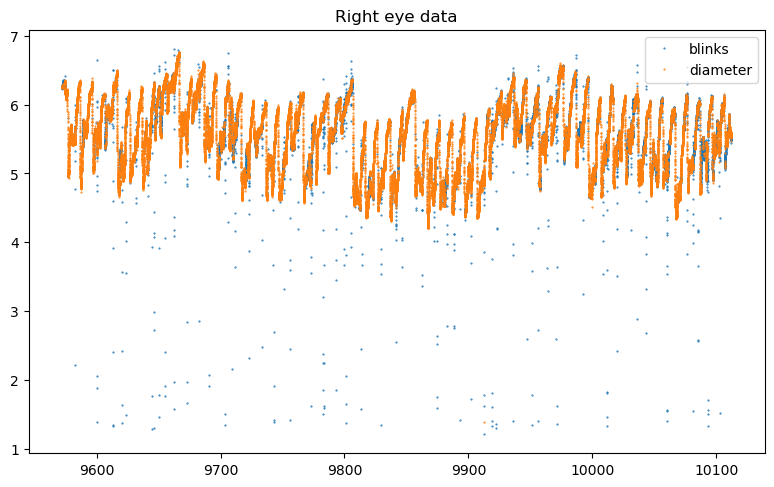

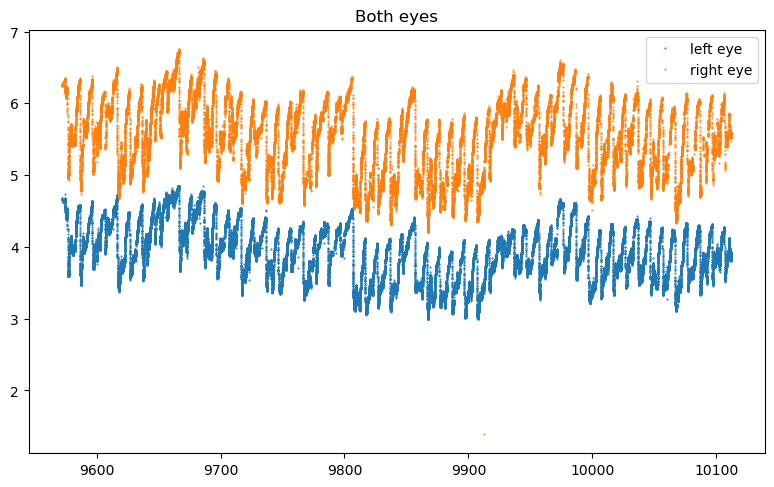

In [15]:
%matplotlib inline
#for left eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_left_eye['pupil_timestamp'],blinks_left_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Left eye data')

#for right eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_right_eye['pupil_timestamp'],blinks_right_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Right eye data')

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['left eye','right eye'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Both eyes')



### Do cubic splines aeasily, in the future use a better blink detection algorithm

In [16]:
%matplotlib qt


fig, ax = plt.subplots(2,1,figsize=(15, 8))
ax[0].plot(pupil_left_eye_interpolated['pupil_timestamp'], pupil_left_eye_interpolated['diameter_3d'], 'o', label='data')
ax[0].plot(pupil_left_eye_interpolated['pupil_timestamp'], pupil_left_eye_interpolated['diameter_3d_cubic'],'.', label="interpolated")
ax[0].legend(loc='lower right', ncol=2)
ax[0].set_title('left eye')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('diameter (mm)')


ax[1].plot(pupil_right_eye_interpolated['pupil_timestamp'], pupil_right_eye_interpolated['diameter_3d'], 'o', label='data')
ax[1].plot(pupil_right_eye_interpolated['pupil_timestamp'], pupil_right_eye_interpolated['diameter_3d_cubic'],'.', label="interpolated")
ax[1].legend(loc='lower right', ncol=2)
ax[1].set_title('right eye')
ax[1].set_xlabel('sample')
ax[1].set_ylabel('diameter (mm)')
fig.tight_layout()

usaing smooting splines

## 

In [17]:
time_col_str='timestamp_s'
signal_str='diameter_3d'
sns.set_theme()

%matplotlib qt
fig1, ax=plt.subplots(1,)
ax.plot(pupil_left_eye[time_col_str],pupil_left_eye[signal_str],'.')
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row[time_col_str], color='r', label='axvline - full height')
    ax.text((row[time_col_str]),3,row['label'])
ax.set_title('pupil diameter and events')    
ax.set_xlabel(f'{time_col_str}')
ax.set_ylabel(f'{signal_str}')
fig1.set_size_inches((18, 5.5))

fig2, ax=plt.subplots(1)
ax.plot(pupil_left_eye[time_col_str],pupil_left_eye[signal_str],'.')
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row[time_col_str], color='r', label='axvline - full height')
    ax.text((row[time_col_str]),3,row['label'])
ax.set_title('pupil diameter and events')    
ax.set_xlabel(f'{time_col_str}')
ax.set_ylabel(f'{signal_str}')
fig2.set_size_inches((18, 5.5))

# plt.tight_layout()

## Apply normalizations


### Create different normalization columns

In [18]:
pupil_left_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_left_eye_interpolated['diameter_3d_cubic'],
                                            type='z_score')

pupil_right_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_right_eye_interpolated['diameter_3d_cubic'],
                                            type='z_score')

pupil_left_eye['diameter_3d_z_score']=nm.normalize(values=pupil_left_eye['diameter_3d'],
                                            type='z_score')

pupil_right_eye['diameter_3d_z_score']=nm.normalize(values=pupil_right_eye['diameter_3d'],
                                            type='z_score')
pupil_left_eye.head()

C:\Users\arturoV\AppData\Local\Temp\ipykernel_13156\2016220940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_left_eye_interpolated['diameter_3d_cubic'],
C:\Users\arturoV\AppData\Local\Temp\ipykernel_13156\2016220940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_right_eye_interpolated['diameter_3d_cubic'],
C:\Users\arturoV\AppData\L

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,join_index,on_surf,timestamp_s,diameter_3d_z_score
29753,9572.237214,7630,1,1.0,0.410697,0.409990,46.034292,pye3d 0.3.0 real-time,78.853867,113.281995,...,-2.158703,117.154698,129.508621,170.025058,170.025058,0.0,NaN,True,0.000000,1.978461
29764,9572.261283,7632,1,1.0,0.411005,0.409822,45.970929,pye3d 0.3.0 real-time,78.913003,113.314158,...,-2.157470,117.154698,129.508621,170.025058,170.025058,0.0,NaN,True,0.024069,1.960273
29798,9572.333201,7636,1,1.0,0.410769,0.409980,46.057251,pye3d 0.3.0 real-time,78.867611,113.283755,...,-2.160309,117.154698,129.508621,170.025058,170.025058,0.0,NaN,True,0.095987,1.983674
29832,9572.397243,7640,1,1.0,0.411086,0.410369,45.870961,pye3d 0.3.0 real-time,78.928487,113.209201,...,-2.154813,117.154698,129.508621,170.025058,170.025058,0.0,NaN,True,0.160029,1.935455
29856,9572.445203,7643,1,1.0,0.414414,0.401879,45.894380,pye3d 0.3.0 real-time,79.567404,114.839138,...,-2.136085,117.154698,129.508621,170.025058,170.025058,0.0,NaN,True,0.207989,1.920375


### Filters

In [19]:
filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


### Asset normalization

In [20]:
#common variables for analysis
pupil_df=pupil_left_eye
signal_str='diameter_3d_z_score'
secons_norm=0.05 # preestimulus frame to normalize
window_s=2.7  # winsow of interest 

# pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100).rolling(3).median())

frames_norm=np.round(secons_norm*pupil_sampling_freq_left).astype(int)
win_norm=range(frames_norm)
print('Initial frames used for normalization = {} correspond to {}s'.format(frames_norm,secons_norm))

window_frames=np.round(window_s*pupil_sampling_freq_left).astype(int)
print('Windows frames of interest   = {} correspond to {}s'.format(window_frames,window_s))
window=range(0,window_frames)
time_x=np.linspace(0,window_s,window_frames)



Initial frames used for normalization = 6 correspond to 0.05s
Windows frames of interest   = 335 correspond to 2.7s


In [21]:
# For Assets only window size data
event=annotations_pd.loc[filter_events,['label']].values.flatten()
# event=annotations_pd['label'].values.flatten()
data_dict=dict([(key,[None]) for key in event])# dict with empty keys 

pupil_diameter_df=pd.DataFrame()#pd.DataFrame(data_dict,index=np.arange(0,800))
data_list=[]
for num,im in enumerate(event):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )
    
    segmented_df=segmented_df.iloc[window]
    win_blank=segmented_df.iloc[win_norm]
    asset_norm=segmented_df[signal_str]-win_blank[signal_str].mean()
    asset_raw=segmented_df[signal_str]
    data_dict[im]=asset_norm.values
pupil_diameter_df=pd.DataFrame(data_dict)


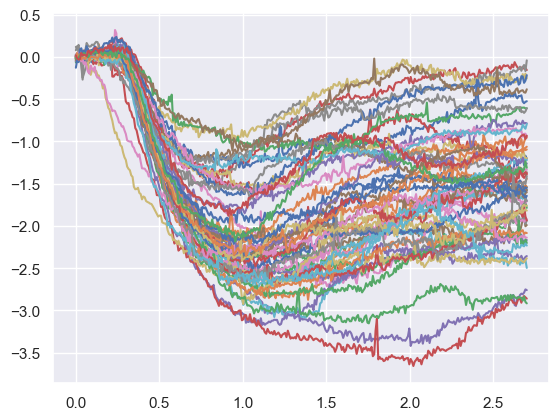

In [22]:
%matplotlib inline
df_plot=pupil_diameter_df
plt.plot(time_x,df_plot)


### With thius new data format i can easily filter out assets with z_scores higher than 2

In [23]:
pupil_diameter_df.describe()

,Asset0015.tif,Asset0034.tif,Asset0004.tif,Asset0010.tif,Asset0048.tif,Asset0026.tif,Asset0044.tif,Asset0016.tif,Asset0040.tif,Surprise02.tif,...,Asset0030.tif,Asset0033.tif,Asset0002.tif,Asset0046.tif,Asset0024.tif,Asset0001.tif,Asset0008.tif,Asset0006.tif,Asset0042.tif,Asset0037.tif
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,-1.471837,-1.777282,-1.636416,-0.527890,-2.382682,-1.756902,-1.647851,-0.619940,-0.410995,-1.862678,...,-1.346348,-1.438605,-1.783568,-1.843234,-1.699272,-1.941493,-1.432290,-1.456553,-1.243791,-1.058488
std,0.727714,0.861492,0.768729,0.467798,1.182233,0.762807,0.860109,0.449999,0.303965,0.935358,...,0.662938,0.670075,0.591486,0.794662,0.736487,0.815071,0.638412,0.693360,0.607605,0.535949
min,-2.376506,-2.874832,-2.421388,-1.425622,-3.420810,-2.444661,-2.714353,-1.532724,-0.975330,-3.085836,...,-2.300894,-2.186364,-2.386084,-2.660594,-2.411859,-2.700569,-2.213850,-2.358363,-2.183982,-1.879968
25%,-2.095354,-2.481685,-2.249598,-0.948866,-3.208874,-2.219396,-2.381679,-0.960393,-0.717720,-2.666480,...,-1.903463,-2.030934,-2.197733,-2.347409,-2.080230,-2.540644,-1.835016,-2.005604,-1.577440,-1.370476
50%,-1.451190,-1.817188,-1.798063,-0.435482,-2.990271,-2.099051,-1.786905,-0.530622,-0.305200,-1.868787,...,-1.272734,-1.563586,-1.949963,-2.145657,-2.010019,-2.232447,-1.558702,-1.576635,-1.346459,-1.145365
75%,-1.342494,-1.557362,-1.540092,-0.174598,-1.877979,-1.821323,-1.319054,-0.309507,-0.168620,-1.608168,...,-1.186016,-1.133100,-1.691026,-1.799159,-1.764134,-1.870840,-1.494010,-1.159693,-1.023469,-0.939212
max,0.121228,0.077496,0.102082,0.219558,0.147638,0.043552,0.112587,0.127193,0.050949,0.053202,...,0.061480,0.080343,0.049778,0.143626,0.048612,0.012702,0.133752,0.067680,0.084727,0.147697


### Do the plots

In [24]:
%matplotlib qt
even_asset=annotations_pd.loc[filter_events,['label']].values.flatten()


mat=pupil_diameter_df.reindex(columns=
                                  even_asset)
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat)
ax.plot(time_x,np.mean(mat,axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')

event_surprise=annotations_pd.loc[filter_events_surprise,['label']].values.flatten()

mat2=pupil_diameter_df.reindex(columns=
                                  event_surprise)
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat2)
ax.plot(time_x,np.mean(mat2,axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
# ax.errorbar(time_x,np.median(pupil_diameter_df,axis=1),np.std(pupil_diameter_df,axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.mean(mat,axis=1),linewidth=2,color='black')
ax.errorbar(time_x,np.mean(mat,axis=1),np.std(mat,axis=1),linewidth=0.5,color='blue')
ax.plot(time_x,np.mean(mat2,axis=1),linewidth=2,color='black')
ax.errorbar(time_x,np.mean(mat2,axis=1),np.std(mat2,axis=1),linewidth=0.5,color='red')

# ax.legend(['surprise','assets'])
# ax.set_title('Mean pupilometry')
# ax.set_xlabel('time (s)')
# ax.set_ylabel('speed (s)')

<ErrorbarContainer object of 3 artists>

In [25]:
np.median(pupil_diameter_df,axis=1)

array([-5.76092951e-03,  7.57850501e-03,  9.92432759e-03, -4.37696693e-03,
        5.03477401e-05,  2.79913547e-03,  7.10516647e-03,  1.25621672e-02,
        9.40662321e-03, -4.65853232e-03,  8.55363951e-03,  1.72698090e-02,
        1.53160313e-02,  1.34259203e-02,  8.38974696e-03,  1.52975591e-02,
        2.12931767e-02,  2.05890242e-02,  2.44341132e-02,  1.69598916e-02,
        1.49079158e-02,  1.99990522e-02,  2.80090581e-02,  2.43272327e-02,
        1.13671265e-02,  9.31093406e-03,  1.29231811e-02,  1.60497000e-02,
        1.41001564e-02,  1.16005817e-02,  8.13563601e-03,  2.53634258e-02,
        9.44250034e-03, -8.35195986e-03, -7.08822629e-03, -2.07969593e-02,
       -3.04251516e-02, -5.51505767e-02, -7.74010102e-02, -9.99873104e-02,
       -1.38027572e-01, -1.77954704e-01, -2.12497930e-01, -2.52464456e-01,
       -2.95025268e-01, -3.53517933e-01, -4.04087630e-01, -4.47244247e-01,
       -4.95524042e-01, -5.79748084e-01, -6.19291691e-01, -6.59028216e-01,
       -6.99475720e-01, -

In [26]:

mat=pupil_diameter_df.reindex(columns=
                                  even_asset).values
mat[window]


array([[-0.00414654, -0.00540757, -0.06722752, ...,  0.00630534,
        -0.01461351,  0.01615742],
       [ 0.03102505,  0.01118691, -0.03574672, ...,  0.0369217 ,
        -0.0239861 , -0.01848946],
       [ 0.00187064, -0.0131464 ,  0.05017266, ..., -0.03223222,
        -0.01433509, -0.03084907],
       ...,
       [-1.28138252, -1.48652384, -1.55270732, ..., -1.08118076,
        -1.33106671, -0.92242973],
       [-1.17011052, -1.47435827, -1.55196692, ..., -1.10398135,
        -1.23584611, -0.97147762],
       [-1.20615867, -1.44131722, -1.54062067, ..., -1.09640318,
        -1.31272824, -0.93362025]])

## Now lets calculate the speed of change from the normalized data

In [27]:

pupil_events_speed=np.abs(np.diff(pupil_events_matrix))
pupil_surprise_speed=np.abs(np.diff(pupil_surprise_matrix))

NameError: name 'pupil_events_matrix' is not defined

Text(0, 0.5, 'speed (s)')

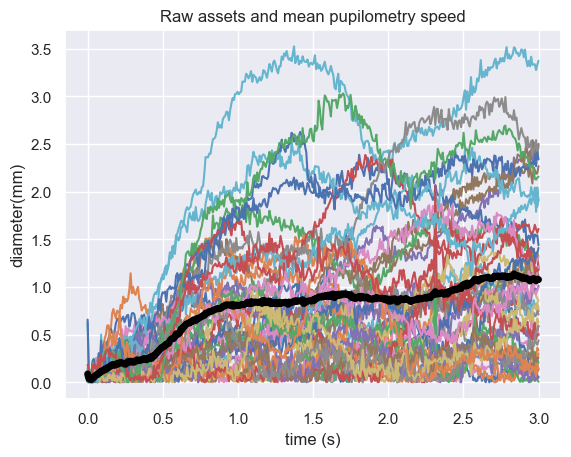

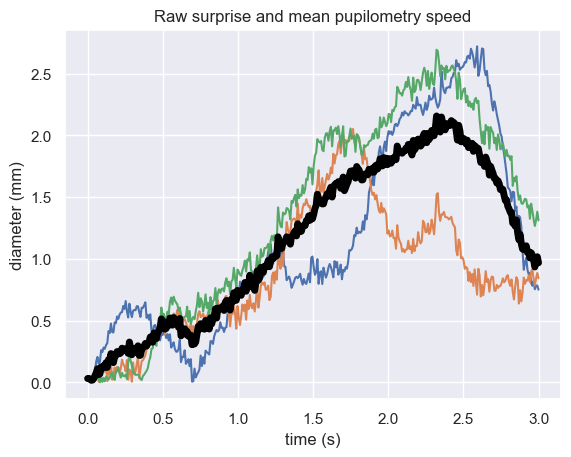

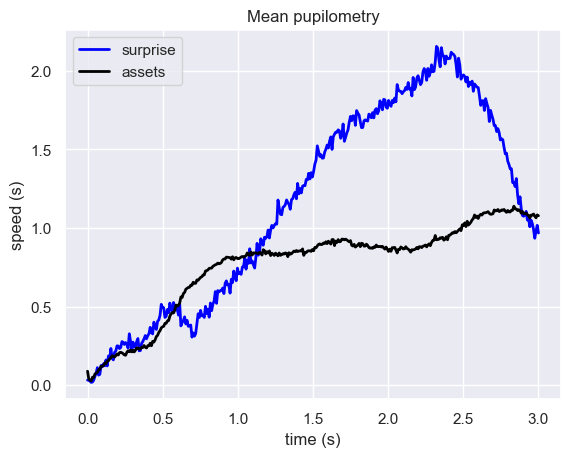

In [ ]:
%matplotlib inline

mat1=pupil_events_speed
mat2=pupil_surprise_speed

fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat1[window])
ax.plot(time_x,np.mean(mat1[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')

fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat2[window,:])
ax.plot(time_x,np.mean(mat2[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(time_x,np.mean(mat2[window,:],axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.mean(mat1[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

Exclude data that is over [2,-2] z scores


NameError: name 'pupil_zscore' is not defined

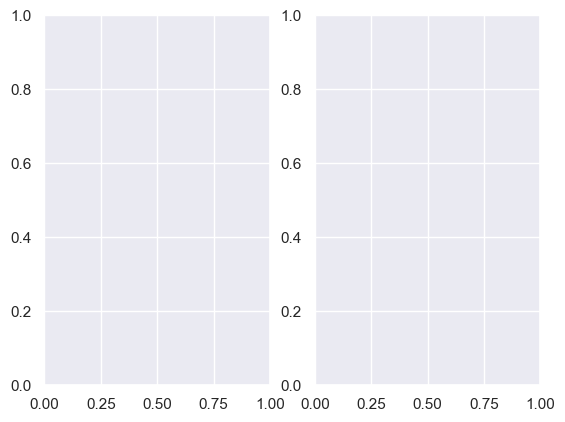

In [ ]:
fig,ax=plt.subplots(1,2)
sns.histplot(pupil_zscore[window,6],ax=ax[0])
sns.histplot(pupil_events_matrix[window,6],ax=ax[1])

In [ ]:
#test sfuntion
sigma=1
mu=10
data_normal=sigma*np.random.randn(70,100) +mu
data_norm=nm.normalize(values=data_normal.reshape(data_normal.size),
                                            type='z_score').reshape(data_normal.shape)
plt.plot(data_normal,'.',color='red')
plt.plot(data_norm,'.',color='blue')
plt.plot(data_normal-10,'.',color='green')


In [ ]:
plt.hist(data_normal)


In [ ]:
pupil_events_matrix.shape[0]

In [ ]:
r=a.reshape(pupil_events_matrix.shape)

In [ ]:
pupil_events_matrix.shape[0]*pupil_events_matrix.shape[1]

In [ ]:
pupil_events_matrix.shape

In [ ]:
# pupil_list=[]
# surface_list=[]
# ref_col=surfaces_pd_frame.columns.get_indexer(['gaze_timestamp'])[0]

# for row in range(20,200):#(surfaces_pd_frame.shape[0]-1):
#         ini_val=surfaces_pd_frame.iloc[row,ref_col]
#         end_value=surfaces_pd_frame.iloc[row+1,ref_col]
#         surface_row=surfaces_pd_frame.iloc[row:row+1]
#         # print(ini_val,end_value)
#         aux_pd_frame=cm.filter_rows_by_temporal_values(
#                 dataframe=pupil_pd_frame,
#                 time_column='pupil_timestamp',
#                 ini_value=ini_val,
#                 end_value=end_value
#                 )
#         aux_pd_frame.insert(0,'horizontal_index',row)
#         surface_row.insert(0,'horizontal_index',row)
#         # aux_pd_frame=aux_pd_frame.join(to_join,rsuffisx='sur_',how='cross')

#         pupil_list.append(aux_pd_frame)
#         surface_list.append(surface_row)
# # final_df=pd.concat(final_df,axis=0)
# # display(final_df)
        
# vert_stack=pd.concat(pupil_list,axis=0)
# horz_stack=pd.concat(surface_list,axis=0)
# vert_stack.head()
# final_df=[]
# for row,index in surfaces_pd_frame.iterrows():
#         ini_val=surfaces_pd_frame.iloc[row]['gaze_timestamp']
#         end_value=surfaces_pd_frame.iloc[row+1]['gaze_timestamp']
#         to_join=surfaces_pd_frame.iloc[row:row+1]
#         # print(ini_val,end_value)
#         aux_pd_frame=cm.filter_rows_by_temporal_values(
#                 dataframe=pupil_pd_frame,
#                 time_column='pupil_timestamp',
#                 ini_value=ini_val,
#                 end_value=end_value
#                 )

#         # aux_pd_frame=aux_pd_frame.join(to_join,rsuffix='sur_',how='cross')
#         final_df.append(aux_pd_frame)
# # final_df=pd.concat(final_df,axis=0)
# # display(final_df)


In [ ]:
df_A = pd.DataFrame({'start_date':['2017-03-27','2017-01-10'],'end_date':['2017-04-20','2017-02-01']})
df_B = pd.DataFrame({'event_date':['2017-01-20','2017-01-27'],'price':[100,200]})

df_A['end_date'] = pd.to_datetime(df_A.end_date)
df_A['start_date'] = pd.to_datetime(df_A.start_date)
df_B['event_date'] = pd.to_datetime(df_B.event_date)
df_B

,event_date,price
0,2017-01-20,100
1,2017-01-27,200


In [ ]:
df_merge = df_A.merge(df_B, how='cross')
df_merge

,start_date,end_date,event_date,price
0,2017-03-27,2017-04-20,2017-01-20,100
1,2017-03-27,2017-04-20,2017-01-27,200
2,2017-01-10,2017-02-01,2017-01-20,100
3,2017-01-10,2017-02-01,2017-01-27,200


In [ ]:
df_merge = df_merge.query('event_date >= start_date and event_date <= end_date')
df_merge

,start_date,end_date,event_date,price
2,2017-01-10,2017-02-01,2017-01-20,100
3,2017-01-10,2017-02-01,2017-01-27,200


In [ ]:
surfaces_pd_frame['start']=surfaces_pd_frame['gaze_timestamp']
surfaces_pd_frame['end']=np.append(surfaces_pd_frame['gaze_timestamp'].values[1:],0)
surfaces_pd_frame.drop(surfaces_pd_frame.tail(1).index,inplace=True)
surfaces_pd_frame['event']=np.arange(len(surfaces_pd_frame))
# idx = pd.IntervalIndex.from_arrays(surfaces_pd_frame['start'], df_2['end'], closed='both')

In [ ]:
surfaces_pd_frame.index = pd.IntervalIndex.from_arrays(surfaces_pd_frame['start'],surfaces_pd_frame['end'],closed='both')
surfaces_pd_frame

,world_timestamp,world_index,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence,start,end,event
"[14963.464168400002, 14963.468149400003]",14963.529049,0,14963.464168,0.390105,-0.042263,0.390105,-0.042263,False,0.990000,14963.464168,14963.468149,0
"[14963.468149400003, 14963.472153400002]",14963.529049,0,14963.468149,0.385552,-0.102956,0.385552,-0.102956,False,0.990000,14963.468149,14963.472153,1
"[14963.472153400002, 14963.476132400005]",14963.529049,0,14963.472153,0.379080,-0.151352,0.379080,-0.151352,False,0.990000,14963.472153,14963.476132,2
"[14963.476132400005, 14963.4801314]",14963.529049,0,14963.476132,0.373581,-0.219004,0.373581,-0.219004,False,0.990000,14963.476132,14963.480131,3
"[14963.4801314, 14963.4841224]",14963.529049,0,14963.480131,0.366127,-0.282971,0.366127,-0.282971,False,0.990000,14963.480131,14963.484122,4
...,...,...,...,...,...,...,...,...,...,...,...,...
"[15616.681685400004, 15616.685702400002]",15616.684612,38927,15616.681685,0.353888,0.368990,0.353888,0.368990,True,0.918658,15616.681685,15616.685702,159420
"[15616.685702400002, 15616.6896554]",15616.684612,38927,15616.685702,0.333188,0.345879,0.333188,0.345879,True,0.937488,15616.685702,15616.689655,159421
"[15616.6896554, 15616.693664400002]",15616.684612,38927,15616.689655,0.321895,0.354199,0.321895,0.354199,True,0.937488,15616.689655,15616.693664,159422
"[15616.693664400002, 15616.697709400005]",15616.700605,38928,15616.693664,0.296020,0.369735,0.296020,0.369735,True,0.913507,15616.693664,15616.697709,159423


In [ ]:
pupil_pd_frame['event'] = pupil_pd_frame['pupil_timestamp'].apply(lambda x : surfaces_pd_frame.iloc[surfaces_pd_frame.index.get_loc(x)]['event'])

KeyError: 15616.703703400002